In [1]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
)

In [2]:
from src.nas.mlp_chromosome import RawChromosome


RawChromosome.get_bounds()

(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), array([7, 8, 3, 7, 2, 3, 1, 1, 6, 3]))

In [2]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import MlpNasParams
from src.datasets.vertebral_dataset import VertebralDataset


params = MlpNasParams(
    epochs=3,
    patience=5,
    amount_of_evaluations=1,
    population_size=30,
    population_offspring_count=10,
    algorithm_generations=3,
    population_store_file="population.csv",
)
problem = MlpNasProblem(params, VertebralDataset)

problem._get_min_complexity(), problem._get_max_complexity()

INFO: Loading cached vertebral from /home/nurdaulett/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl


(np.float64(81.0), np.float64(2851.2))

In [ ]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file loaded successfully


In [8]:
from dataclasses import asdict

from pprint import pprint
import pandas as pd


df = pd.DataFrame()

for i in range(len(res.X)):
    x = res.X[i]
    f = res.F[i]
    accuracy = problem.denormalize(-f[0], 0, 100)
    complexity = problem.denormalize(f[1], problem._get_min_complexity(), problem._get_max_complexity())
    ch = RawChromosome(x).parse()
    params = problem.get_nn_params(ch)
    
    
    df = pd.concat([
        df,
        pd.DataFrame([{
            "Accuracy": accuracy,
            "Complexity": complexity,
            **asdict(params),
            "Chromosome": x,
        }])
    ], ignore_index=True)

df

,Accuracy,Complexity,in_height,hidden_height,out_height,model_layers,in_bitwidth,hidden_bitwidth,activation,dropout_rate,learning_rate,weight_decay,epochs,quantization_mode,Chromosome
0,67.741935,96.261101,6,1,3,3,6,7,ActivationModule.BINARIZE_RESTE,0.2,0.0100,0.005,3,QMode.STOCH,"[5, 1, 1, 6, 2, 1, 1, 0, 6, 1]"
1,50.000000,81.000000,6,1,3,2,3,5,ActivationModule.TERNARIZE,0.0,0.0020,0.001,3,QMode.DET,"[2, 1, 0, 4, 0, 3, 0, 0, 4, 3]"
2,74.193548,424.940760,6,4,3,3,6,4,ActivationModule.BINARIZE,0.1,0.0002,0.010,3,QMode.DET,"[5, 4, 1, 3, 1, 2, 0, 1, 1, 0]"
3,72.580645,388.800000,6,6,3,2,4,4,ActivationModule.BINARIZE_RESTE,0.1,0.0100,0.010,3,QMode.DET,"[3, 6, 0, 3, 1, 1, 0, 1, 6, 0]"


In [ ]:
ch = RawChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(in_height=6,
          hidden_height=np.int64(3),
          out_height=3,
          model_layers=np.int64(3),
          in_bitwidth=1,
          hidden_bitwidth=2,
          activation=<ActivationModule.BINARIZE_RESTE: 'binary_ReSTE'>,
          dropout_rate=0.2,
          learning_rate=0.002,
          weight_decay=0.005,
          epochs=10,
          quantization_mode=<QMode.STOCH: 'stoch'>)


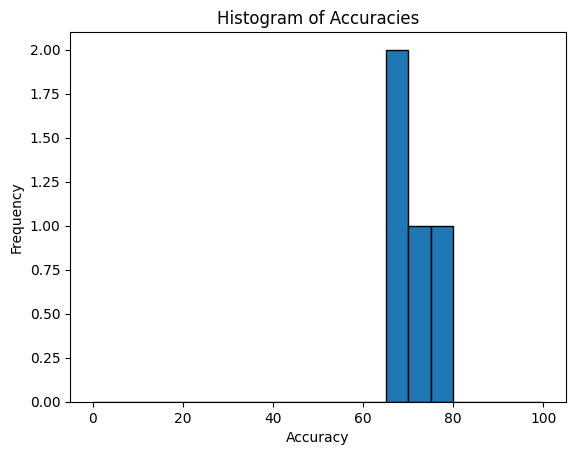

In [ ]:
from matplotlib import pyplot as plt

from src.models.mlp import MLPEvaluator


def hist_accuracies(accuracies: list[float]) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=20, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies(df["Accuracy"])

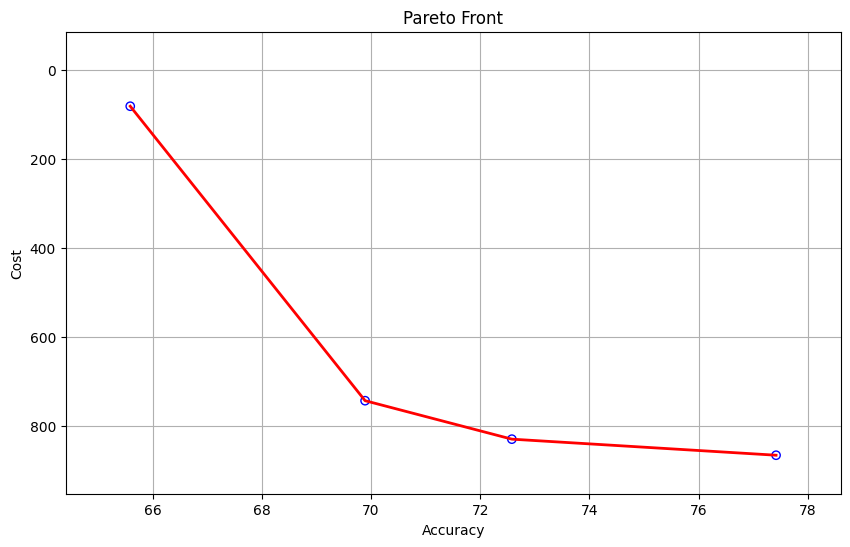

In [ ]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])
